# Multimodal retrieval augmentation generation (mRAG)

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.10.13

## Overview

This notebook demonstrates the implementation of multimodal RAG (mRAG) using an academic article specific to the healthcare domain. mRAGs extract information not only from text but also from other modalities like images, videos, and audio. They are powerful because a significant amount of information can be hidden in images that might not be mentioned in the text.

### Objective
This is a question and answering implementation with images and text using Gemini. I am using a simple prompt to retrieve the anwwer from both image and text. The data is an academic article in pdf format. The notebook performs best when you have both the text and images. As an LLM, I am using Google Cloud ML, Vertex AI and Gemini Pro 1.5. 

The steps performed include:
1. Extract metadata from the pdf article and images
    1. Generate embeddings from metadata
    2. Inspect the embeddigns 
2. Search for the prompt in the text
3. Search for the prompt in the images 
4. Combine image + text 
5. Pass the results and the original prompt to Gemini 1.5 Pro

![alt text](/images/AI%20in%20Healthcare.jpg "Multimodal RAG Architecture")


### Dataset

I used a real-world study on breast cancer that was published in 2020. Here is the [link](https://bmccancer.biomedcentral.com/articles/10.1186/s12885-020-6527-y). The model works better with high-resolution images. I have also downloaded the chart used in the article to aid performance.

## Installation

Install the following packages required to execute this notebook. 

Please upgrade to the latest GA version of each package; i.e., --upgrade

In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform pymupdf rich

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Set up your Google Cloud account and authenticate
Follow the instructions to set up your account and autenticate from [Google's tutorials](https://console.cloud.google.com/cloud-resource-manager). 

In [1]:
# Define project information

import sys

PROJECT_ID = "mRag-on-academic-article"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# if not running on Colab, try to get the PROJECT_ID automatically
if "google.colab" not in sys.modules:
    import subprocess

    PROJECT_ID = subprocess.check_output(
        ["gcloud", "config", "get-value", "project"], text=True
    ).strip()

print(f"Your project ID is: {PROJECT_ID}")

Your project ID is: gcp-tech-innov-vertexai-6abe


### Import libraries

In [2]:
import sys

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

from IPython.display import Markdown, display
from rich.markdown import Markdown as rich_Markdown
from vertexai.generative_models import (
    Content,
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    HarmCategory,
    HarmBlockThreshold,
    Image,
    Part,
)

from intro_multimodal_rag_utils import get_document_metadata

### Initialize the Vertex AI SDK for Python for your project

In [3]:
text_model = GenerativeModel("gemini-1.5-pro")
multimodal_model = GenerativeModel("gemini-1.5-pro-001")
multimodal_model_flash = GenerativeModel("gemini-1.5-flash-001")

## STEP1 - Extracting document metadata from both text and images
To contextualise the search with the images / documents that are interest to us, we need to extract the metadata from our documents. We will then create embeddings to find similar text or image per our prompgt. In addition, the metadata wil be used for references and citations. It includes essencial elements like page numbers, files manes, images counter, etc. 

### STEP 1.1 - Generate Embeddings from the metadata
Embeddings are used to perform similarity search when querying the data. We are extrating metadata from both images and text as there might be information only given in an image and vice versa. 

``` get_document_metadata() ``` : extract text & image metadata from the document. Returns two data frames ```text_metadata``` and ```image_metadata```. 


### STEP 1.2 - Analyse the embeddings 
Using the functions below, check if the embeddings are correct for your data. 
- ```text_metadata```:
    - ```text```: the original text from the page
    - ```text_embedding_page```: the embedding of the original text from the page
    - ```chunk_tex```: the original text divided into smaller chunks
    - ```chunk_number```: the index of each text chunk
    - ```text_embedding_chunk```: the embedding of each text chunk
- ```image_metadata```:
    - ```img_desc```: Gemini-generated textual description of the image.
    - ```mm_embedding_from_text_desc_and_img```: Combined embedding of image and its description, capturing both visual and textual information.
    - ```mm_embedding_from_img_only```: Separate text embedding of the generated description, enabling textual analysis and comparison.

### Meta data extraction 

For each page in the pdf file, extract the text and charts. It took ~2sec to run this code for me. 
Charts re saved under the /images folder. 

In [4]:
%%time
pdf_folder_path = "data/"  # if running in Vertex AI Workbench.

# Specify the image description prompt. Change it
image_description_prompt = """Explain what is going on in the image.
If it's a table, extract all elements of the table.
If it's a graph, explain the findings in the graph.
Do not include any numbers that are not mentioned in the image.
"""

# Extract text and image metadata from the PDF document
text_metadata_df, image_metadata_df = get_document_metadata(
    multimodal_model,  # we are passing Gemini 1.5 Pro model
    pdf_folder_path,
    image_save_dir="images",
    image_description_prompt=image_description_prompt,
    embedding_size=1408,
    # add_sleep_after_page = True, # Uncomment this if you are running into API quota issues
    # sleep_time_after_page = 5,
    # generation_config = # see next cell
    # safety_settings =  # see next cell
)

print("\n\n --- Completed processing. ---")



 Processing the file: --------------------------------- data/s12885-020-6527-y.pdf 


Processing page: 1
Extracting image from page: 1, saved as: images/s12885-020-6527-y.pdf_image_0_0_229.jpeg
Extracting image from page: 1, saved as: images/s12885-020-6527-y.pdf_image_0_1_230.jpeg
Extracting image from page: 1, saved as: images/s12885-020-6527-y.pdf_image_0_2_231.jpeg
Processing page: 2
Processing page: 3
Processing page: 4
Processing page: 5
Processing page: 6
Extracting image from page: 6, saved as: images/s12885-020-6527-y.pdf_image_5_0_280.jpeg
Processing page: 7
Extracting image from page: 7, saved as: images/s12885-020-6527-y.pdf_image_6_0_309.jpeg
Processing page: 8
Processing page: 9
Extracting image from page: 9, saved as: images/s12885-020-6527-y.pdf_image_8_0_335.jpeg
Processing page: 10
Processing page: 11
Extracting image from page: 11, saved as: images/s12885-020-6527-y.pdf_image_10_0_375.jpeg
Processing page: 12


 --- Completed processing. ---
CPU times: user 1.6 s, 

## Inspect metadata

In [5]:
text_metadata_df.head()

,file_name,page_num,text,text_embedding_page,chunk_number,chunk_text,text_embedding_chunk
0,s12885-020-6527-y.pdf,1,RESEARCH ARTICLE\nOpen Access\nSystemic treatm...,"[0.027346676215529442, 0.011194429360330105, -...",1,RESEARCH ARTICLE\nOpen Access\nSystemic treatm...,"[0.0300931204110384, -0.017618391662836075, 0...."
1,s12885-020-6527-y.pdf,1,RESEARCH ARTICLE\nOpen Access\nSystemic treatm...,"[0.027346676215529442, 0.011194429360330105, -...",2,were identified with HR+/HER2- MBC. Median ag...,"[0.014839713461697102, -0.006387830246239901, ..."
2,s12885-020-6527-y.pdf,1,RESEARCH ARTICLE\nOpen Access\nSystemic treatm...,"[0.027346676215529442, 0.011194429360330105, -...",3,ng effective\nand tolerable therapies early.\n...,"[0.03085922822356224, -0.035147421061992645, 0..."
3,s12885-020-6527-y.pdf,1,RESEARCH ARTICLE\nOpen Access\nSystemic treatm...,"[0.027346676215529442, 0.011194429360330105, -...",4,thors.\n1Clinical Cancer Pharmacology and Onco...,"[-0.006659112870693207, 0.02086830325424671, -..."
4,s12885-020-6527-y.pdf,2,Background\nBreast cancer (BC) is biologically...,"[0.01987052708864212, -0.019887985661625862, -...",1,Background\nBreast cancer (BC) is biologically...,"[0.050600361078977585, -0.008597150444984436, ..."


In [6]:
image_metadata_df.head()

,file_name,page_num,img_num,img_path,img_desc,mm_embedding_from_img_only,text_embedding_from_image_description
0,s12885-020-6527-y.pdf,1,1,images/s12885-020-6527-y.pdf_image_0_0_229.jpeg,"The image shows the text ""BMC Cancer"". It is n...","[-0.00392717076, 0.0333489403, 0.0139185237, -...","[-0.00587098253890872, 0.06393181532621384, 0...."
1,s12885-020-6527-y.pdf,1,2,images/s12885-020-6527-y.pdf_image_0_1_230.jpeg,The image is a gray triangle on a white backgr...,"[0.0161345676, 0.0502022058, 0.0203375816, 0.0...","[0.03076809085905552, 0.03615700453519821, -0...."
2,s12885-020-6527-y.pdf,1,3,images/s12885-020-6527-y.pdf_image_0_2_231.jpeg,The image is a solid turquoise color. There is...,"[0.00580317155, 0.0479596071, 0.00753476145, 0...","[0.02176755480468273, 0.06311490386724472, 0.0..."
3,s12885-020-6527-y.pdf,6,1,images/s12885-020-6527-y.pdf_image_5_0_280.jpeg,The image shows two graphs. \n\nThe left graph...,"[0.0328628719, 0.000922116451, -0.0658040568, ...","[0.05161052942276001, 0.006455648690462112, -0..."
4,s12885-020-6527-y.pdf,7,1,images/s12885-020-6527-y.pdf_image_6_0_309.jpeg,The image consists of two donut charts labeled...,"[0.0172985028, -0.0215803143, -0.0485819913, -...","[0.06256940960884094, 0.01483200117945671, -0...."


## Import Helper Functions

```/utils/intro_multimodal_rag_utils.py``` includes the helper functions. 

- ```get_similar_text_from_query()```: Given a text query, finds text from the document which are relevant, using cosine similarity algorithm. It uses text embeddings from the metadata to compute and the results can be filtered by top score, page/chunk number, or embedding size.
- ```print_text_to_text_citation()```: Prints the source (citation) and details of the retrieved text from the get_similar_text_from_query() function.
- ```get_similar_image_from_query()```: Given an image path or an image, finds images from the document which are relevant. It uses image embeddings from the metadata.
- ```print_text_to_image_citation()```: Prints the source (citation) and the details of retrieved images from the get_similar_image_from_query() function.
- ```get_gemini_response()```: Interacts with a Gemini model to answer questions based on a combination of text and image inputs.
- ```display_images()```: Displays a series of images provided as paths or PIL Image objects.

In [7]:
from intro_multimodal_rag_utils import (
    get_similar_text_from_query,
    print_text_to_text_citation,
    get_similar_image_from_query,
    print_text_to_image_citation,
    get_gemini_response,
    display_images,
)

## Text Search

Search similar text for given prompt. This will only search within the text part of the pdf. I am printing the citations. 

In [8]:
query = "How many patients received chemotherapy as first line of therapy"

# Matching user text query with "chunk_embedding" to find relevant chunks.
matching_results_text = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=3,
    chunk_text=True,
)

# Print the matched text citations
print_text_to_text_citation(matching_results_text, print_top=False, chunk_text=True)

Citation 1: Matched text: 

score:  0.75
file_name:  s12885-020-6527-y.pdf
page_number:  5
chunk_number:  1
chunk_text:  60.8% [n = 90], respectively), this difference was not sta-
tistically significant (p = 0.11).
Endocrine therapy
Endocrine therapy was the modality most frequently
used as 1st LoT (n = 127, 68.6%), with a further 12
(6.5%) receiving endocrine/targeted
therapy. Median
treatment duration of 1st LoT endocrine (with/without
targeted) therapy was 382 days (range 131708). Patients
treated with 1st LoT endocrine most commonly received
an AI (114 patients, 82.0%); tamoxifen (8.6%) or exemes-
tane/everolimus in combination (8.6%) were used less
frequently (Table 2).
Chemotherapy
Forty-six patients (24.9%) received 1st LoT chemother-
apy and median treatment duration was 129 days (range
24278). The proportion of patients receiving 1st LoT
chemotherapy appeared to decrease between 2012 and
2017 (33.3 and 15.4%, respectively), although this trend
was not statistically significan

### Same prompt but output via Gemini LLM 

LLM returns the correct answerm which is written in page 5 in the article.

In [9]:
print("\n **** Result: ***** \n")

# All relevant text chunk found across documents based on user query
context = "\n".join(
    [value["chunk_text"] for key, value in matching_results_text.items()]
)

instruction = f"""Answer the question with the given context.
If the information is not available in the context, just return "not available in the context".
Question: {query}
Context: {context}
Answer:
"""

# Prepare the model input
model_input = instruction

# Generate Gemini response with streaming output
get_gemini_response(
    text_model,  # we are passing Gemini 1.0 Pro
    model_input=model_input,
    stream=True,
    generation_config=GenerationConfig(temperature=0.2),
)


 **** Result: ***** 



'Forty-six patients received chemotherapy as the first line of therapy. \n'

## Search for similar images with text query

The same prompt is used agains the image. Sunburs shart given in figure 2 / page 7 is correctly identified. 


 **** Result: ***** 



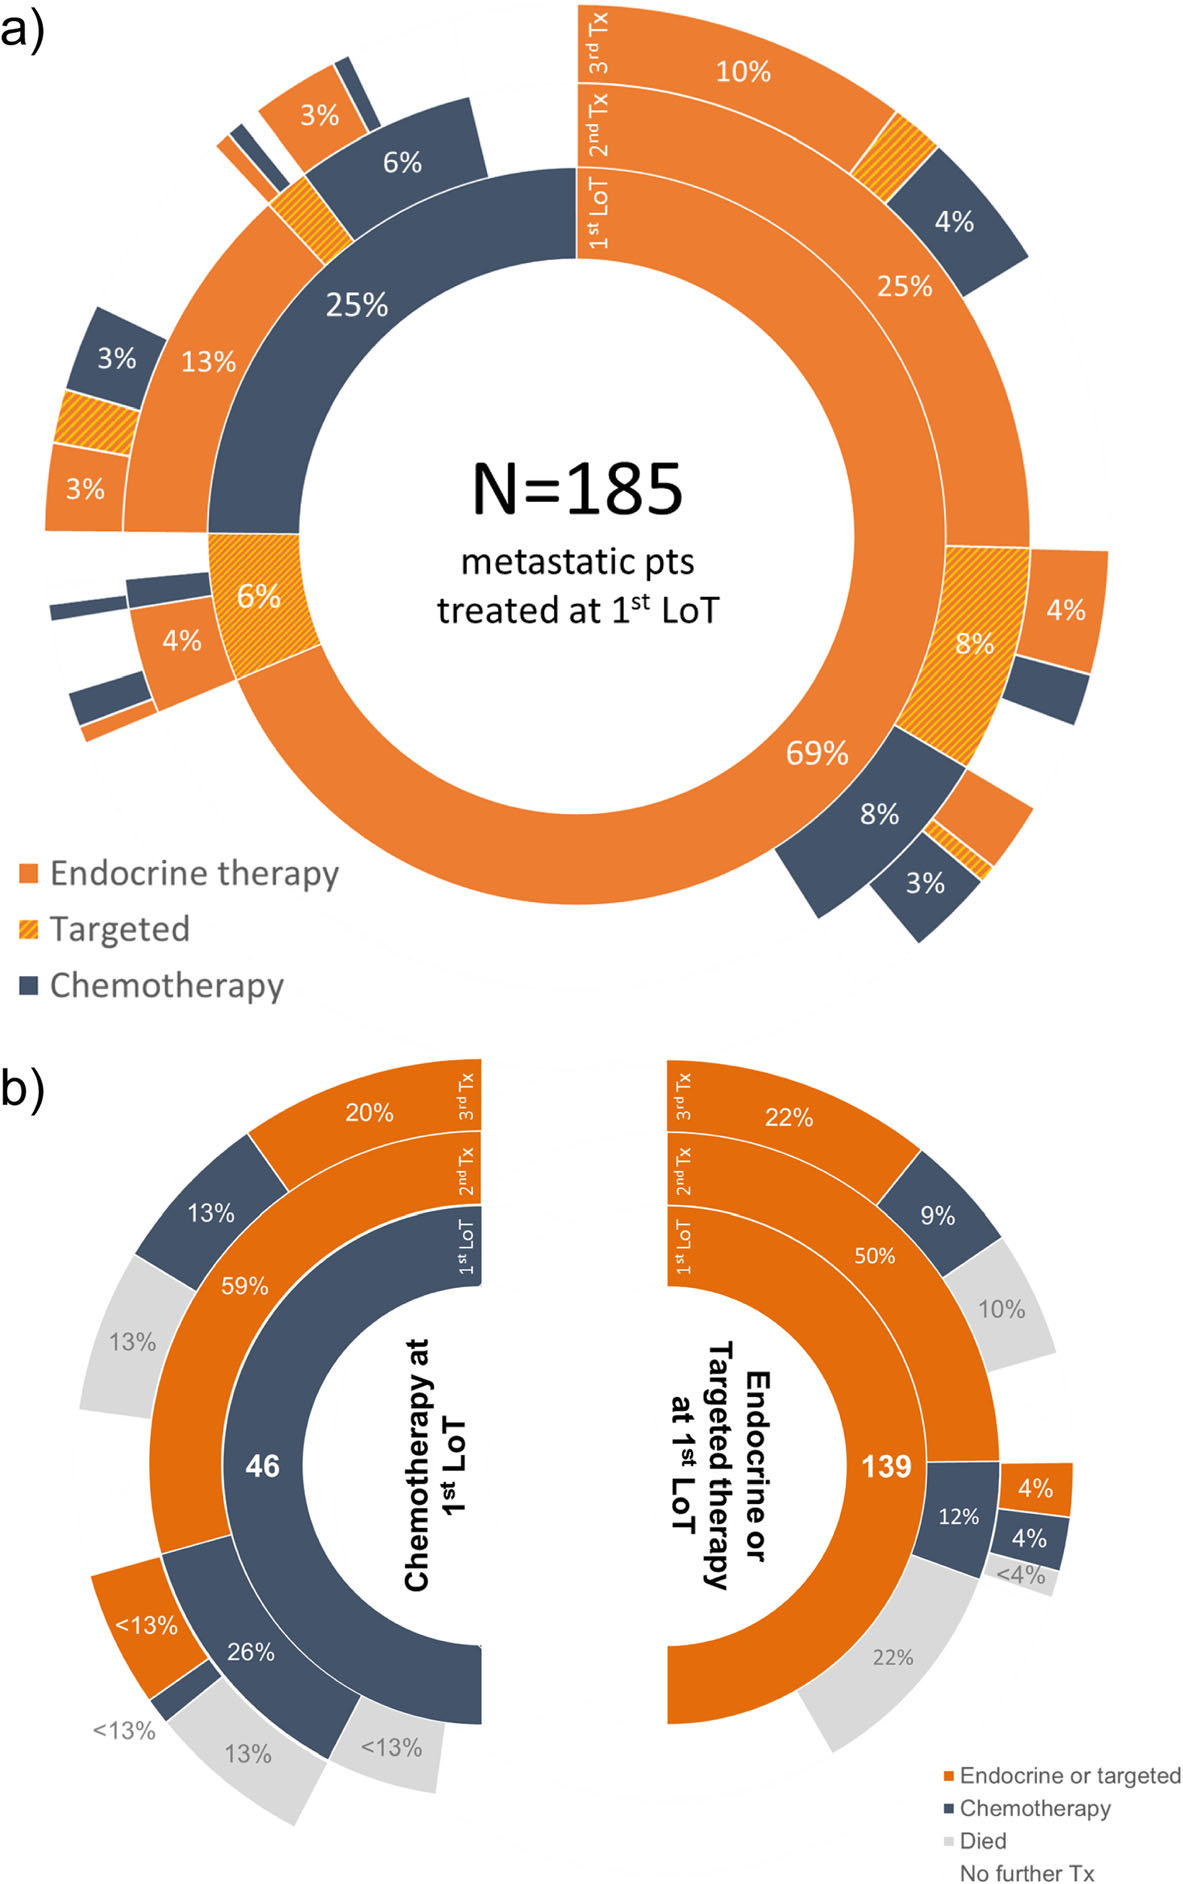

In [16]:
query = "How many patients received chemotherapy as first line of therapy"

matching_results_image = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",  # Use image description text embedding
    image_emb=False,  # Use text embedding instead of image embedding
    top_n=3,
    embedding_size=1408,
)

# Markdown(print_text_to_image_citation(matching_results_image, print_top=True))
print("\n **** Result: ***** \n")

# Display the top matching image
display(matching_results_image[0]["image_object"])

The answer should be 46 patients, but 4% is returned instead. Image search isn't providing a correct information. 

In [17]:
print("\n **** Result: ***** \n")

# All relevant text chunk found across documents based on user query
context = f"""Image: {matching_results_image[0]['image_object']}
Description: {matching_results_image[0]['image_description']}
"""

instruction = f"""Answer the question in JSON format with the given context of Image and its Description. Only include value.
Question: {query}
Context: {context}
Answer:
"""

# Prepare the model input
model_input = instruction

# Generate Gemini response with streaming output
Markdown(
    get_gemini_response(
        multimodal_model_flash,  # we are passing Gemini 1.5 Pro Flash
        model_input=model_input,
        stream=True,
        generation_config=GenerationConfig(temperature=1),
    )
)


 **** Result: ***** 



```json
"4%"
```

Let's investivate the citations to understand the core of the problem.

In [18]:
## you can check the citations to probe further.
## check the "image description:" which is a description extracted through Gemini which helped search our query.
Markdown(print_text_to_image_citation(matching_results_image, print_top=True))

Citation 1: Matched image path, page number and page text: 

score:  0.68
file_name:  s12885-020-6527-y.pdf
path:  images/s12885-020-6527-y.pdf_image_6_0_309.jpeg
page number:  7
page text:  chemotherapy (n = 28, 22.6%) (Fig. 2a). When given, 3rd
LoT was again more often endocrine (with/without tar-
geted) therapy (n = 49, 65.3%) than chemotherapy (n =
26, 34.7%).
There was substantial diversity in the sequence of
SACT classes and regimens used (Additional file 2). One
line of endocrine therapy with a single agent AI, was the
treatment sequence used most frequently (27.6%, n = 51
patients). The next most common were three successive
lines (n = 19, 10.3%) and two successive lines (n = 17,
9.2%) of endocrine therapy, each without targeted ther-
apy. The fourth most common treatment sequence was
the first to include chemotherapy, (3rd LoT capecitabine
following endocrine therapy; n = 8, 4.3%).
Patients receiving 1st LoT chemotherapy were more
likely
than those
receiving endocrine
(with/wi

<IPython.core.display.Markdown object>

## Build multimodal RAG (mRAG)

### Step 1: User Prompt

In [19]:
# this time we are not passing any images, but just a simple text query.

query = """Questions:
 - How many patients received chemotherapy as first line of therapy?
 - Can you summarise the paper in 3 sentences?
 - Who are the authors and their corresponsing institutions?
 - Summary of the patient population
 - Which patient group has the highest survival rate?
 - Which treatment group has the highest survival rate?
 """

### Step 2: Return all relevant text chunks based on the prompt


In [21]:
# Retrieve relevant chunks of text based on the query
matching_results_chunks_data = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=10,
    chunk_text=True,
)

### Step 3: Return all relevant images based on the prompt

In [22]:
# Get all relevant images based on user query
matching_results_image_fromdescription_data = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",
    image_emb=False,
    top_n=10,
    embedding_size=1408,
)

### Step 4: Combine text with image

In [23]:
# combine all the selected relevant text chunks
context_text = []
for key, value in matching_results_chunks_data.items():
    context_text.append(value["chunk_text"])
final_context_text = "\n".join(context_text)

# combine all the relevant images and their description generated by Gemini
context_images = []
for key, value in matching_results_image_fromdescription_data.items():
    context_images.extend(
        ["Image: ", value["image_object"], "Caption: ", value["image_description"]]
    )

### Step 5: Pass context to Gemini

In [24]:
prompt = f""" Instructions: Compare the images and the text provided as Context: to answer multiple Question:
Make sure to think thoroughly before answering the question and put the necessary steps to arrive at the answer in bullet points for easy explainability.
If unsure, respond, "Not enough context to answer".

Context:
 - Text Context:
 {final_context_text}
 - Image Context:
 {context_images}

{query}

Answer:
"""

# Generate Gemini response with streaming output
rich_Markdown(
    get_gemini_response(
        multimodal_model,
        model_input=[prompt],
        stream=True,
        generation_config=GenerationConfig(temperature=1),
    )
)

Here are the answers to your questions:                                                                            

 • How many patients received chemotherapy as first line of therapy?                                               
    • The text states "Forty-six patients (24.9%) received 1st LoT chemotherapy". Therefore, 46 patients received  
      chemotherapy as the first line of therapy.                                                                   
 • Can you summarise the paper in 3 sentences?                                                                     
    • This study examined treatment patterns and overall survival in a cohort of 192 patients with hormone         
      receptor-positive/human epidermal growth factor receptor 2-negative metastatic breast cancer. The majority of
      patients received endocrine therapy as the first line of systemic treatment, with chemotherapy use decreasing
      over time.  Patients receiving first-line chemotherapy tended to be younger, have more aggressive disease    
      characteristics, and experienced comparable overall survival to those receiving endocrine therapy.           
 • Who are the authors and their corresponsing institutions?                                                       
    • Not enough context to answer.  While the images show an excerpt from a "Twelves et al." publication in BMC   
      Cancer, the full author list and affiliations are not provided.                                              
 • Summary of the patient population                                                                               
    • The study included 192 patients with HR+/HER2- metastatic breast cancer. The median age was 67 years, with   
      85.2% being post-menopausal. The median time between primary diagnosis and metastasis was 5.4 years. Most    
      patients (75.1%) received endocrine therapy as their initial systemic treatment.                             
 • Which patient group has the highest survival rate?                                                              
    • The text states that "OS was significantly better for patients with exclusively non-visceral metastasis than 
      those with visceral metastasis (median 36.9 months and 22.8 months, respectively; p < 0.01)". Therefore,     
      patients with exclusively non-visceral metastasis had the highest survival rate.                             
 • Which treatment group has the highest survival rate?                                                            
    • While the text mentions that median OS was numerically longer for those receiving endocrine therapy (31.7    
      months) compared to chemotherapy (22.5 months), this difference was not statistically significant (p=0.11).  
      Therefore, we cannot definitively conclude that one treatment group had a significantly higher survival rate 
      based on this study alone.

#### Print references and citations

---------------Matched Images------------------



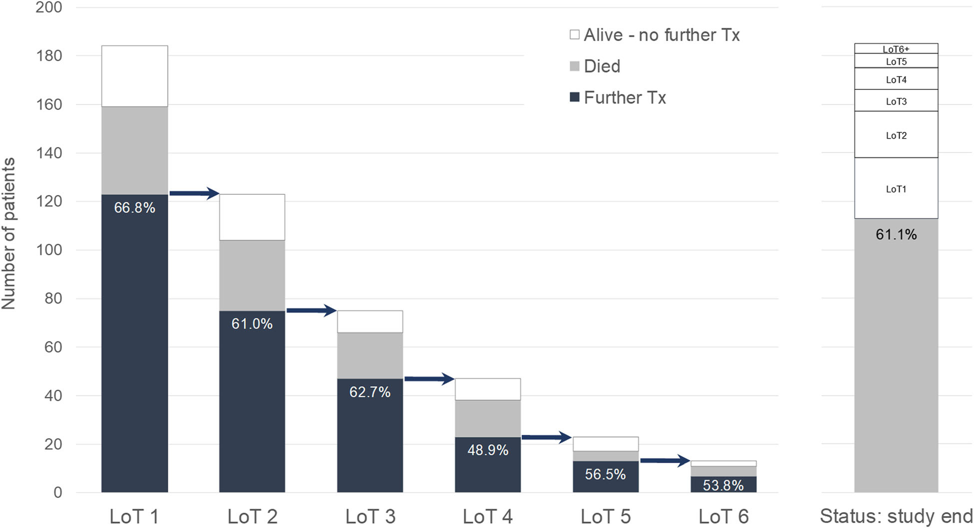

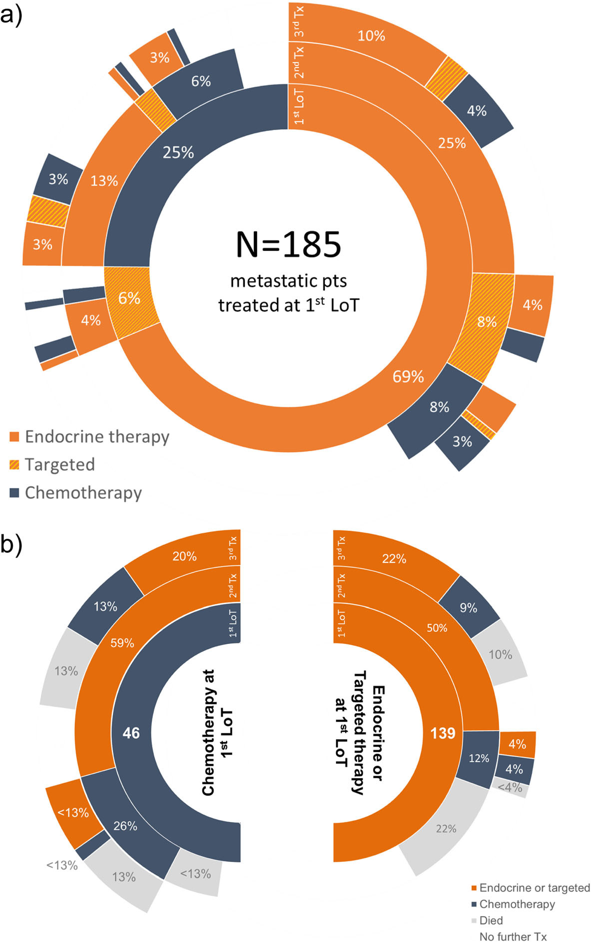

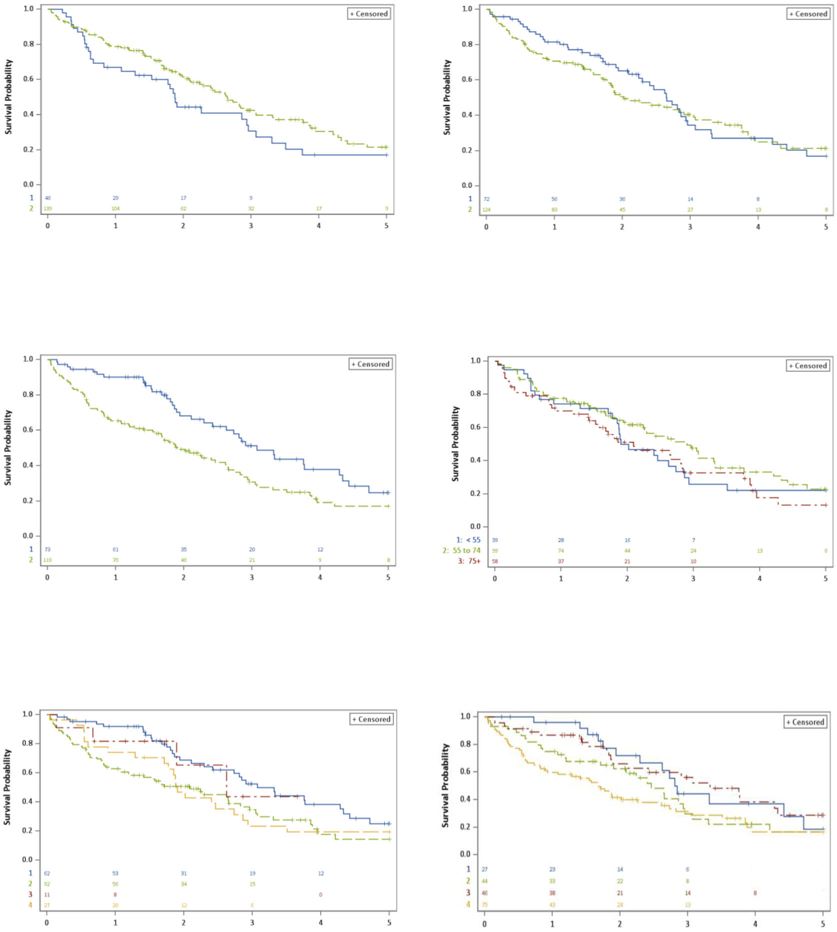

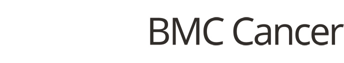

In [25]:
print("---------------Matched Images------------------\n")
display_images(
    [
        matching_results_image_fromdescription_data[0]["img_path"],
        matching_results_image_fromdescription_data[1]["img_path"],
        matching_results_image_fromdescription_data[2]["img_path"],
        matching_results_image_fromdescription_data[3]["img_path"],
    ],
    resize_ratio=0.5,
)

In [26]:
# Image citations. You can check how Gemini generated metadata helped in grounding the answer.

print_text_to_image_citation(
    matching_results_image_fromdescription_data, print_top=False
)

Citation 1: Matched image path, page number and page text: 

score:  0.68
file_name:  s12885-020-6527-y.pdf
path:  images/s12885-020-6527-y.pdf_image_5_0_280.jpeg
page number:  6
page text:  64.1%, falling to 51.8% following 4th to 6th LoT (Fig. 1).
Of those receiving 1st LoT chemotherapy, 39 (84.8%)
had subsequent SACT, compared with 84 (60.4%) of
those receiving 1st LoT endocrine (with/without tar-
geted) therapy (p < 0.01). The extent to which this subse-
quent treatment represents maintenance endocrine
therapy without disease progression is, however, not
known.
Following 1st LoT endocrine (with/without targeted)
therapy or chemotherapy, 62 patients did not receive
subsequent SACT; 36 of these patients (58.0%) died dur-
ing or following 1st LoT, the remainder either having
completed or continuing 1st LoT. Following 2nd LoT
SACT, 48 patients did not receive further SACT, 29
(60.4%) having died during or following 2nd LoT. By the
end of the study period, 61.1% treated patients had die

In [27]:
# Text citations

print_text_to_text_citation(
    matching_results_chunks_data,
    print_top=False,
    chunk_text=True,
)

Citation 1: Matched text: 

score:  0.7
file_name:  s12885-020-6527-y.pdf
page_number:  6
chunk_number:  3
chunk_text:  )
22 (39.3%)
< 6
41 (35.7%)
p < 0.001
Endo +/targ
8 (32.0%)
34 (60.7%)
32 (94.1%)
74 (64.3%)
All (n = 181)
Chemo
18 (54.5%)
24 (25.3%)
< 6
46 (25.4%)
p < 0.001
Endo +/targ
15 (45.5%)
71 (74.7%)
49 (92.5%)
135 (74.6%)
aFreeman-Halton Fisher exact test statistic
Chemo Chemotherapy, Endo +/targ Endocrine (with or without targeted) therapy
Fig. 1 Treatment (Tx) outcomes for each distinct LoT (up to 6 LoT shown), including status at end of study. The percentage of patients receiving
subsequent treatment (shown by an arrow between bars) is labelled. The numbers of patients dying before receiving subsequent treatment are
distinguished from those remaining alive without a change of treatment before end of study period
Twelves et al. BMC Cancer           (2020) 20:53 
Page 6 of 12

Citation 2: Matched text: 

score:  0.69
file_name:  s12885-020-6527-y.pdf
page_number:  5
chunk

## Conclusions

Multimodal RAG can be very powerful as it incorporates information not only from text, but also images too. 

However, it is important to note the limitations of mRAG: 
- Be careful with domain specific tasks: This tasks is specific to healthcare and has many abbreviations. Some of the inconsistencies are related to that. Using a glossary can help overcome the challanges.
- Data dependency: Needs high-quality paired text and visuals. Adding the chats as independen
- Computationally demanding: Processing multimodal data is resource-intensive.
- Domain specific: Models trained on general data may not shine in specialized fields like medicine.
- Black box: Understanding how these models work can be tricky, hindering trust and adoption.

Despite these challenges, multimodal RAG represents a significant step towards search and retrieval systems that can handle diverse, multimodal data.